In [1]:
!pip install datasets soundfile speechbrain

In [2]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to c:\users\alexc\appdata\local\temp\pip-req-build-1cb6v41u
  Resolved https://github.com/huggingface/transformers.git to commit 6c3f168b36882f0beebaa9121eafa1928ba29633
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git 'C:\Users\alexc\AppData\Local\Temp\pip-req-build-1cb6v41u'


In [3]:
!pip install --upgrade accelerate

Do we have a GPU?

In [4]:
!nvidia-smi

Tue Nov 26 19:52:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              8W /   45W |       2MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again but for a new language. For more info about the original checkpoint, you can find its model card on the [Hugging Face Hub](https://huggingface.co/microsoft/speecht5_tts).

In [244]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

## Load the dataset

We'll fine-tune on the Spanish (language code `es`) examples from VoxPopuli.


In [29]:
from datasets import load_dataset, Audio

# Cargar el dataset de Common Voice
dataset = load_dataset("mozilla-foundation/common_voice_13_0", "es", split="train", trust_remote_code=True)

# Convertir la columna de audio al formato correcto
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Inspeccionar el dataset
print(dataset)


n_shards.json:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

es_train_0.tar:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

es_train_1.tar:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

es_train_2.tar:   0%|          | 0.00/1.66G [00:00<?, ?B/s]

es_train_3.tar:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

es_train_4.tar:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

es_train_5.tar:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

es_train_6.tar:   0%|          | 0.00/1.55G [00:00<?, ?B/s]

es_train_7.tar:   0%|          | 0.00/9.68M [00:00<?, ?B/s]

es_dev_0.tar:   0%|          | 0.00/767M [00:00<?, ?B/s]

es_test_0.tar:   0%|          | 0.00/755M [00:00<?, ?B/s]

es_other_15.tar:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

es_other_6.tar:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

es_other_0.tar:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

es_other_9.tar:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

es_other_1.tar:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

es_other_3.tar:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

es_other_13.tar:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

es_other_8.tar:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

es_other_4.tar:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

es_other_14.tar:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

es_other_11.tar:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

es_other_7.tar:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

es_other_12.tar:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

es_other_5.tar:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

es_other_10.tar:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

es_other_2.tar:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

es_other_16.tar:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

es_other_17.tar:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

es_other_18.tar:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

es_other_19.tar:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

es_other_20.tar:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

es_other_21.tar:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

es_other_22.tar:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

es_other_23.tar:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

es_other_24.tar:   0%|          | 0.00/952M [00:00<?, ?B/s]

es_other_25.tar:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

es_other_26.tar:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

es_other_27.tar:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

es_other_28.tar:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

es_other_29.tar:   0%|          | 0.00/237M [00:00<?, ?B/s]

es_invalidated_0.tar:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

es_invalidated_1.tar:   0%|          | 0.00/975M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/78.5M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/3.86M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

other.tsv:   0%|          | 0.00/301M [00:00<?, ?B/s]

invalidated.tsv:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Reading metadata...: 280329it [00:01, 147232.08it/s]


Generating validation split: 0 examples [00:00, ? examples/s]

Reading metadata...: 15708it [00:00, 184799.40it/s]


Generating test split: 0 examples [00:00, ? examples/s]

Reading metadata...: 15708it [00:00, 203976.26it/s]


Generating other split: 0 examples [00:00, ? examples/s]

Reading metadata...: 1167766it [00:06, 186679.68it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]

Reading metadata...: 68143it [00:00, 220490.58it/s]


Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 280329
})


In [88]:
from datasets import load_dataset

# Dataset ya cargado (asegúrate de que esté en memoria)
dataset = load_dataset("mozilla-foundation/common_voice_13_0", "es", split="train")

# Guardar el dataset en tu directorio actual (por ejemplo, "./common_voice_dataset")
save_path = "./common_voice_dataset"
dataset.save_to_disk(save_path)

print(f"Dataset guardado en: {save_path}")


Saving the dataset (0/26 shards):   0%|          | 0/280329 [00:00<?, ? examples/s]

OSError: [Errno 22] Invalid argument: 'c:/Proyectos/Film_recomendations/common_voice_dataset/data-00000-of-00026.arrow'

In [89]:
from datasets import load_from_disk

# Cargar el dataset desde el directorio guardado
dataset = load_from_disk("./common_voice_dataset")
print(dataset)

Loading dataset from disk:   0%|          | 0/26 [00:00<?, ?it/s]

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 280329
})


It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [90]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [91]:
from datasets import Dataset

# Sobrescribir 'dataset' con una muestra del 10%
dataset = dataset.shuffle(seed=42).select(range(int(len(dataset) * 0.5)))

# Inspeccionar la muestra
print(dataset)

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 140164
})


That should be sufficient for fine-tuning. We'll have a closer look at these examples soon.

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to `<unk>` tokens. However, in Dutch a character such as `à` is used to stress syllables and so we can simply replace it with `a` without changing its meaning. The tokenizer supports some characters with diacritical marks, such as `é`, but not all of them.

Note that the VoxPopuli examples have both `raw_text` and `normalized_text`, which is all lowercase. The SpeechT5 tokenizer can handle uppercase just fine, however, it doesn't have any tokens for numbers. The `normalized_text` has the numbers written out as text, so we'll use that.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [92]:
tokenizer = processor.tokenizer

In [97]:
# Definir la función para extraer todos los caracteres únicos del dataset
def extract_all_chars(batch):
    # Concatenar todos los textos de la columna 'sentence' en un solo string
    all_text = " ".join(batch["sentence"])
    # Extraer caracteres únicos
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

# Aplicar la función al dataset
vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,  # Procesar todo en un solo lote
    keep_in_memory=True,
    remove_columns=dataset.column_names  # Eliminar columnas originales para que no ocupen memoria
)

# Extraer el vocabulario del dataset
dataset_vocab = set(vocabs["vocab"][0])

# Obtener el vocabulario del tokenizer
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}


Map:   0%|          | 0/140164 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [98]:
# Inspeccionar caracteres no soportados por el tokenizer
unsupported_chars = dataset_vocab - tokenizer_vocab
print("Caracteres no soportados:", unsupported_chars)

Caracteres no soportados: {'ý', '…', '–', '´', 'н', 'ਸ', 'ñ', 'ه', 'ð', 'Ś', 'С', 'Ø', 'ė', '下', '„', 'Ö', 'ä', '利', 'ੰ', '”', 'к', 'ī', '市', 'ã', 'ਾ', 'ਿ', 'т', '̪', 'ô', 'ş', 'ذ', 'В', 'í', 'ň', 'е', 'ي', '飲', 'ù', 'ч', '降', 'ı', '_', 'ž', 'Ş', '江', 'ʿ', 'ć', 'ó', 'Ò', 'õ', 'ы', '&', 'ਮ', 'Г', 'đ', 'İ', ' ', 'ø', 'ʻ', '达', 'â', '|', 'ḫ', '新', 'о', 'ț', 'î', '鮨', 'á', '柱', 'ਤ', 'ğ', 'Š', 'ṁ', 'Е', '―', '申', 'ө', 'ř', '«', '≫', 'ń', '鮓', 'п', '¡', 'ª', '°', '“', '́', 'É', 'م', '辿', 'Í', 'ل', 'ś', 'р', 'ﬂ', 'ß', 'ر', 'г', '￼', 'ă', '飧', 'ā', 'Ł', '♯', 'ź', '$', '瑤', '寛', 'و', 'Þ', 'в', 'ę', '阪', 'ю', 'ਆ', '’', 'л', '♭', '=', '·', 'Æ', '`', 'ü', '‘', '到', 'ě', 'б', 'ʷ', 'й', '飢', 'ш', 'ú', 'å', 'Ú', 'ə', '‧', 'ү', 'Ž', 'ا', '致', 'ł', '~', '妻', 'Ō', 'ਨ', 'ː', 'À', 'ṃ', 'с', '≪', 'Б', 'č', 'ʽ', 'د', '浩', '仙', 'Î', 'ਘ', 'ŏ', 'ة', 'û', 'ș', 'ب', 'ï', '道', 'Ó', '»', 'ﬁ', 'Á', '臻', 'ь', 'д', '陀', 'り', '裕', '¿', 'Ñ', 'ō', 'ū', 'š', 'ì', 'リ', 'ë', 'ö', 'Ż', 'и', 'ő', 'а', '分', 'ò'}


Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [ ]:
# Mapeo de reemplazos para caracteres soportados
replacements = [
    ('ñ', 'n'), ('ü', 'u'), ('ö', 'o'), ('ä', 'a'), ('á', 'a'),
    ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('à', 'a'),
    ('è', 'e'), ('ì', 'i'), ('ò', 'o'), ('ù', 'u'),
    ('â', 'a'), ('ê', 'e'), ('î', 'i'), ('ô', 'o'), ('û', 'u'),
    ('ã', 'a'), ('õ', 'o'), ('å', 'a'), ('ë', 'e'), ('ç', 'c'),
    ('ś', 's'), ('ş', 's'), ('ț', 't'), ('þ', 't'), ('ł', 'l'),
    ('ř', 'r'), ('ž', 'z'), ('ż', 'z'), ('ß', 'ss'),
    ('ø', 'o'), ('ý', 'y'), ('ı', 'i'), ('ś', 's'),
    ('Š', 'S'), ('ź', 'z'), ('Ż', 'Z'), ('Č', 'C'),
    ('œ', 'oe'), ('æ', 'ae'), ('đ', 'd'),('K','k')
]

# Cambia "sentence" al nombre real de la columna con texto en tu dataset
text_column = "sentence"

# Función para limpiar el texto
import re

def cleanup_text(inputs):
    text = inputs[text_column]  # Usar el nombre correcto de la columna
    # Reemplazar caracteres mapeados
    for src, dst in replacements:
        text = text.replace(src, dst)
    # Eliminar caracteres restantes no alfanuméricos
    text = re.sub(r"[^a-zA-Z0-9.,!? ]", "", text)
    inputs[text_column] = text
    return inputs

# Aplicar la función al dataset
dataset = dataset.map(cleanup_text)

# Verificar si aún hay caracteres no soportados
def extract_all_chars(batch):
    all_text = " ".join(batch[text_column])
    vocab = list(set(all_text))
    return {"vocab": vocab}

vocabs = dataset.map(
    extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset.column_names
)

dataset_vocab = set(vocabs["vocab"][0])
print(f"Caracteres restantes en el vocabulario: {dataset_vocab}")


Map:   0%|          | 0/140164 [00:00<?, ? examples/s]

Map:   0%|          | 0/140164 [00:00<?, ? examples/s]

Caracteres restantes en el vocabulario: {'w'}


## Speakers

VoxPopuli is a multi-speaker dataset. We know there are 20968 examples in the dataset, but how many speakers are there and how many examples do they have?

In [102]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Crear un diccionario para contar las muestras por locutor
speaker_counts = defaultdict(int)

# Contar las ocurrencias de cada locutor (client_id)
for speaker_id in dataset["client_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram we can get a sense of how much data there is for each speaker.

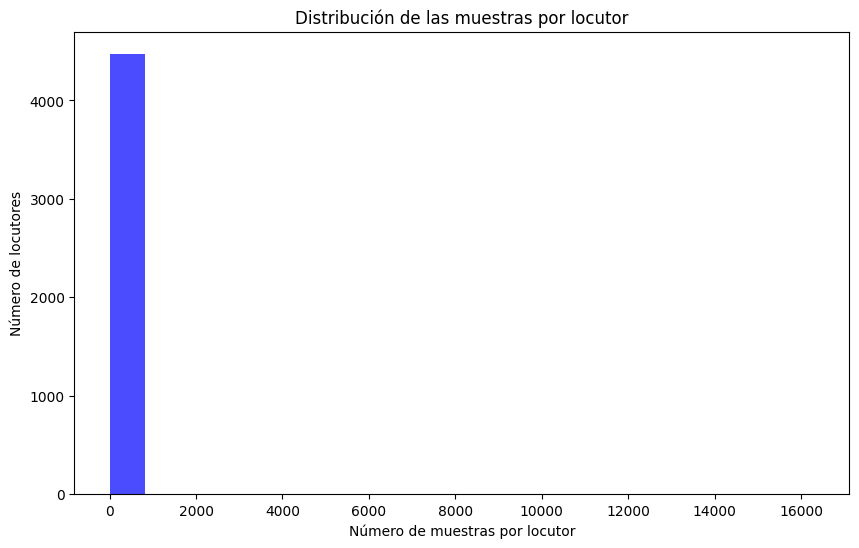

In [103]:
# Graficar un histograma para visualizar la distribución de las muestras por locutor
plt.figure(figsize=(10, 6))
plt.hist(speaker_counts.values(), bins=20, color='blue', alpha=0.7)
plt.ylabel("Número de locutores")
plt.xlabel("Número de muestras por locutor")
plt.title("Distribución de las muestras por locutor")
plt.show()

Around one-third of speakers has fewer than 100 examples. Approximately ten or so speakers have more than 500 examples. To speed up training, let's limit ourselves to speakers that have between 100 and 400 examples. This also makes the dataset more balanced.

In [104]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["client_id"])

Filter:   0%|          | 0/140164 [00:00<?, ? examples/s]

How many speakers remain?

In [105]:
len(set(dataset["client_id"]))

103

And how many examples?

In [106]:
len(dataset)

21135

More than 20k examples and ~100 unique speakers, which should be plenty.

Note: Even better would be to include the lengths of the examples. It's quite possible that speakers with few examples have plenty of audio available if these examples are relatively long. But it takes a while to scan through the entire dataset to find this information (since that requires loading and decoding each audio file), which is why we're skipping it here.

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

Lo hice en generate_embeddings.py

Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

-------------------------------------------------------------- Todo eso esta en script py

Let's verify the processing is correct by looking at a single example:

In [245]:
from datasets import load_from_disk

# Ruta al dataset procesado
processed_dataset_path = "./processed_dataset"

# Cargar el dataset procesado desde el disco
processed_dataset = load_from_disk(processed_dataset_path)
print(f"Dataset procesado cargado correctamente. Número de ejemplos: {len(processed_dataset)}")


Dataset procesado cargado correctamente. Número de ejemplos: 36523


In [246]:
processed_example = processed_dataset[0]

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [247]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [248]:
tokenizer.decode(processed_example["input_ids"])

'Esta situacion propicia que cantabros y vascones puedan disfrutar de cierto grado de independencia.</s>'

Speaker embeddings should be a 512-element vector:

In [249]:
# processed_example["speaker_embeddings"].shape
torch.tensor(processed_example["speaker_embeddings"]).shape


torch.Size([512])

The labels should be a log-mel spectrogram with 80 mel bins.

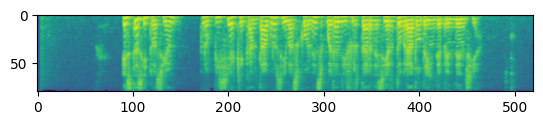

In [250]:
import torch
import matplotlib.pyplot as plt

# Convertir a tensor antes de transponer
labels_tensor = torch.tensor(processed_example["labels"])
plt.figure()
plt.imshow(labels_tensor.T)  # Ahora debería funcionar
plt.show()


If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [253]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [254]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [255]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

processed_dataset = processed_dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/36523 [00:00<?, ? examples/s]

How many examples are left?

In [256]:
len(processed_dataset)

36523

## Train/test split

Create a basic train/test split. For our purposes, it's OK if the same speaker is part of both sets.

In [261]:
dataset = processed_dataset

In [262]:
dataset = dataset.train_test_split(test_size=0.2)

What does the dataset look like now?

In [263]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 29218
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 7305
    })
})

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [264]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [265]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [266]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [267]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 70]),
 'attention_mask': torch.Size([3, 70]),
 'labels': torch.Size([3, 394, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

In [268]:
from huggingface_hub import notebook_login

notebook_login()

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [269]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [270]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_common_voice_es",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

c:\Users\alexc\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1570: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [271]:
# !pip install tensorboard

In [272]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

C:\Users\alexc\AppData\Local\Temp\ipykernel_38344\4196592502.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [273]:
trainer.train()

  0%|          | 0/4000 [00:00<?, ?it/s]

{'loss': 1.1347, 'grad_norm': 31.171409606933594, 'learning_rate': 4.4e-07, 'epoch': 0.03}
{'loss': 1.0056, 'grad_norm': 13.560568809509277, 'learning_rate': 9.400000000000001e-07, 'epoch': 0.05}
{'loss': 0.8984, 'grad_norm': 7.514273166656494, 'learning_rate': 1.44e-06, 'epoch': 0.08}
{'loss': 0.8194, 'grad_norm': 13.201337814331055, 'learning_rate': 1.94e-06, 'epoch': 0.11}
{'loss': 0.8134, 'grad_norm': 11.294214248657227, 'learning_rate': 2.4400000000000004e-06, 'epoch': 0.14}
{'loss': 0.7886, 'grad_norm': 4.958462238311768, 'learning_rate': 2.9400000000000002e-06, 'epoch': 0.16}
{'loss': 0.7671, 'grad_norm': 5.695639133453369, 'learning_rate': 3.44e-06, 'epoch': 0.19}
{'loss': 0.7719, 'grad_norm': 5.66873836517334, 'learning_rate': 3.94e-06, 'epoch': 0.22}
{'loss': 0.7383, 'grad_norm': 11.171318054199219, 'learning_rate': 4.440000000000001e-06, 'epoch': 0.25}
{'loss': 0.7316, 'grad_norm': 9.072537422180176, 'learning_rate': 4.94e-06, 'epoch': 0.27}
{'loss': 0.7165, 'grad_norm': 7.9

  0%|          | 0/914 [00:00<?, ?it/s]

{'eval_loss': 0.49010905623435974, 'eval_runtime': 494.9234, 'eval_samples_per_second': 14.76, 'eval_steps_per_second': 1.847, 'epoch': 1.09}


c:\Users\alexc\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:2774: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'loss': 0.5403, 'grad_norm': 3.545581102371216, 'learning_rate': 8.50857142857143e-06, 'epoch': 1.12}
{'loss': 0.5323, 'grad_norm': 5.778023719787598, 'learning_rate': 8.437142857142859e-06, 'epoch': 1.15}
{'loss': 0.5332, 'grad_norm': 3.4480955600738525, 'learning_rate': 8.365714285714286e-06, 'epoch': 1.18}
{'loss': 0.543, 'grad_norm': 4.21112060546875, 'learning_rate': 8.294285714285715e-06, 'epoch': 1.2}
{'loss': 0.5338, 'grad_norm': 4.578843116760254, 'learning_rate': 8.222857142857144e-06, 'epoch': 1.23}
{'loss': 0.5336, 'grad_norm': 4.740799427032471, 'learning_rate': 8.151428571428572e-06, 'epoch': 1.26}
{'loss': 0.5239, 'grad_norm': 4.107434272766113, 'learning_rate': 8.08e-06, 'epoch': 1.29}
{'loss': 0.5294, 'grad_norm': 4.769303798675537, 'learning_rate': 8.00857142857143e-06, 'epoch': 1.31}
{'loss': 0.549, 'grad_norm': 4.366378307342529, 'learning_rate': 7.937142857142857e-06, 'epoch': 1.34}
{'loss': 0.5214, 'grad_norm': 4.32176399230957, 'learning_rate': 7.865714285714286

  0%|          | 0/914 [00:00<?, ?it/s]

{'eval_loss': 0.47603750228881836, 'eval_runtime': 549.93, 'eval_samples_per_second': 13.284, 'eval_steps_per_second': 1.662, 'epoch': 2.19}
{'loss': 0.5293, 'grad_norm': 5.395664691925049, 'learning_rate': 5.651428571428572e-06, 'epoch': 2.22}
{'loss': 0.5178, 'grad_norm': 8.067560195922852, 'learning_rate': 5.580000000000001e-06, 'epoch': 2.24}
{'loss': 0.5075, 'grad_norm': 4.679161071777344, 'learning_rate': 5.508571428571429e-06, 'epoch': 2.27}
{'loss': 0.5106, 'grad_norm': 5.391317844390869, 'learning_rate': 5.437142857142857e-06, 'epoch': 2.3}
{'loss': 0.5169, 'grad_norm': 5.030940055847168, 'learning_rate': 5.365714285714286e-06, 'epoch': 2.33}
{'loss': 0.5139, 'grad_norm': 9.66469669342041, 'learning_rate': 5.294285714285715e-06, 'epoch': 2.35}
{'loss': 0.5131, 'grad_norm': 5.6115922927856445, 'learning_rate': 5.2228571428571425e-06, 'epoch': 2.38}
{'loss': 0.5119, 'grad_norm': 4.500589370727539, 'learning_rate': 5.154285714285715e-06, 'epoch': 2.41}
{'loss': 0.5182, 'grad_norm

  0%|          | 0/914 [00:00<?, ?it/s]

{'eval_loss': 0.47073525190353394, 'eval_runtime': 538.4892, 'eval_samples_per_second': 13.566, 'eval_steps_per_second': 1.697, 'epoch': 3.28}
{'loss': 0.5034, 'grad_norm': 5.6321234703063965, 'learning_rate': 2.797142857142857e-06, 'epoch': 3.31}
{'loss': 0.5101, 'grad_norm': 3.522552013397217, 'learning_rate': 2.725714285714286e-06, 'epoch': 3.34}
{'loss': 0.5093, 'grad_norm': 4.803864002227783, 'learning_rate': 2.654285714285714e-06, 'epoch': 3.36}
{'loss': 0.5106, 'grad_norm': 4.0120530128479, 'learning_rate': 2.582857142857143e-06, 'epoch': 3.39}
{'loss': 0.5191, 'grad_norm': 5.550750732421875, 'learning_rate': 2.5114285714285718e-06, 'epoch': 3.42}
{'loss': 0.513, 'grad_norm': 5.33856201171875, 'learning_rate': 2.4400000000000004e-06, 'epoch': 3.45}
{'loss': 0.5047, 'grad_norm': 4.371726036071777, 'learning_rate': 2.3685714285714285e-06, 'epoch': 3.47}
{'loss': 0.5008, 'grad_norm': 3.98388934135437, 'learning_rate': 2.297142857142857e-06, 'epoch': 3.5}
{'loss': 0.514, 'grad_norm'

  0%|          | 0/914 [00:00<?, ?it/s]

{'eval_loss': 0.4665316343307495, 'eval_runtime': 485.8011, 'eval_samples_per_second': 15.037, 'eval_steps_per_second': 1.881, 'epoch': 4.38}
{'train_runtime': 53218.3538, 'train_samples_per_second': 2.405, 'train_steps_per_second': 0.075, 'train_loss': 0.5491720724105835, 'epoch': 4.38}


TrainOutput(global_step=4000, training_loss=0.5491720724105835, metrics={'train_runtime': 53218.3538, 'train_samples_per_second': 2.405, 'train_steps_per_second': 0.075, 'total_flos': 1.0516847504283648e+16, 'train_loss': 0.5491720724105835, 'epoch': 4.376573617952928})

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_13_0",  # Etiqueta del dataset que usaste
    "dataset": "Common Voice",  # Nombre descriptivo del dataset
    "dataset_args": "config: es, split: train",  # Configuración específica para el dataset
    "language": "es",  # Idioma (Español)
    "model_name": "SpeechT5_TTS_Español",  # Nombre descriptivo de tu modelo
    "finetuned_from": "microsoft/speecht5_tts",  # Indica que se finetuneó desde este modelo base
    "tasks": "text-to-speech",  # Tarea asociada
    "tags": ["speech-synthesis", "tts", "spanish"],  # Etiquetas adicionales relevantes
}


The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

In [277]:
trainer.push_to_hub(**kwargs)

CommitInfo(commit_url='https://huggingface.co/Aleexc12/speecht5_tts_common_voice_es/commit/adda59dee31430f19b811137a3ee3011dd4651f7', commit_message='End of training', commit_description='', oid='adda59dee31430f19b811137a3ee3011dd4651f7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Aleexc12/speecht5_tts_common_voice_es', endpoint='https://huggingface.co', repo_type='model', repo_id='Aleexc12/speecht5_tts_common_voice_es'), pr_revision=None, pr_num=None)

You can now share this model with anyone using the link on the Hub.

## Evaluate

After training finishes, let's use the model to synthesize some speech!

I'm loading the model from the Hugging Face Hub, as the Colab notebook was terminated before training finished (which is why it's a good idea to use `push_to_hub=True` when training).

In [279]:
from transformers import SpeechT5ForTextToSpeech, SpeechT5Processor

model = SpeechT5ForTextToSpeech.from_pretrained("Aleexc12/speecht5_tts_common_voice_es")

config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [280]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define some input text and tokenize it.

In [281]:
text = "hola, me llamo alex y soy un estudiante de grado"

In [ ]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [282]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [283]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

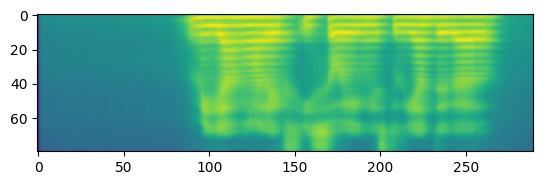

In [284]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [285]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [286]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [242]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)

## Building a demo

To showcase your newly fine-tuned model, make a demo on Hugging Face Spaces! We've created a [template Gradio demo](https://huggingface.co/spaces/Matthijs/speecht5-tts-demo) that you can easily copy and make your own.

Click the link to duplicate the template demo to your account: https://huggingface.co/spaces/Matthijs/speecht5-tts-demo?duplicate=true (or from the three-dot button at the top choose **Duplicate this Space**).

We recommend giving your space a similar name to your fine-tuned model (e.g. `speecht5_tts_voxpopuli_nl`) and setting the visibility to "Public".

Once you've duplicated the Space to your account, click **Files and versions > app.py > edit**. Change the model identifier to your fine-tuned model (line 9). Scroll to the bottom of the page and click **Commit changes to main**. The demo will reboot, this time using your fine-tuned model.

You can share this demo with your friends and family so that they can use the model that you've trained!

## Conclusion

That's it, you've fine-tuned SpeechT5 for TTS on a custom dataset!

In our experience, it can be difficult to get good results out of this model. The results can be rather noisy and sometimes what the model outputs doesn't even sound like speech at all. A lot of this appears to be related to the speaker embeddings. Since SpeechT5 was pre-trained with English x-vectors, it gives the best results using those English speaker embeddings. So if the generated speech sounds bad, try using a different speaker embedding and it might improve.

Of course, the demo above was only trained for 3000 iterations. Training for longer should improve the results. Even so, the speech clearly is Dutch instead of English, and it does capture the voice characteristics of the speaker (compare to the original audio in the example).

Another thing to experiment with is the model's configuration. For example, try using `config.reduction_factor = 1` to see if this improves the results.

A final note on ethical concerns: While TTS technology has many beneficial uses, it can also be used for nefarious purposes such as imitating someone's voice without their permission. Please use TTS wisely and responsibly!